<a href="https://colab.research.google.com/github/Naveenand/Natural-Language-Processing/blob/main/Sentiment_Analysis_with_RNNs%2C_LSTM%2C_GRU%2CConv1D%2C_pre_trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [4]:
BATCH_SIZE=64

# Data Preparation

In [5]:
train_ds,val_ds,test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZXHC77/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZXHC77/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZXHC77/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [6]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
for review,label in val_ds.take(2):
  print(review)
  print(label)

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
tf.Tensor(1, shape=(),

In [8]:
def standardization(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    lowercase=tf.strings.lower(input_data)
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output

In [9]:
standardization(tf.constant("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this movie! would you?<br> <br /><br />T"))

<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie man called t\xc3\xa9v\xc3\xa8z went to a friend\xe2\x80\x99s plce and they had a tensed discussion i don\xe2\x80\x99t love this movie would you t'>

In [10]:
!pip install nltk

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [12]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# Input text
text = "<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this movie! would you?"

# Remove HTML tags
text = BeautifulSoup(text, 'html.parser').get_text()

# Tokenization
tokens = word_tokenize(text)

# Lowercasing and removing punctuation
tokens = [word.lower() for word in tokens if word.isalnum()]

# Remove stopwords (optional, depending on your task)
stop_words = set(stopwords.words('english'))
filtered_tokens = [word for word in tokens if word not in stop_words]

# Stemming (optional, you can choose either stemming or lemmatization)
stemmer = PorterStemmer()
stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

# Lemmatization (optional, you can choose either stemming or lemmatization)
lemmatizer = WordNetLemmatizer()
lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

# Print the preprocessed tokens
print("Original Tokens:", tokens)
print("Filtered Tokens (lowercase, no punctuation, no stopwords):", filtered_tokens)
print("Stemmed Tokens:", stemmed_tokens)
print("Lemmatized Tokens:", lemmatized_tokens)


Original Tokens: ['in', 'the', 'movie', 'man', 'called', 'tévèz', 'went', 'to', 'a', 'friend', 's', 'pl', 'ce', 'and', 'they', 'had', 'a', 'tensed', 'discussion', 'i', 'don', 't', 'love', 'this', 'movie', 'would', 'you']
Filtered Tokens (lowercase, no punctuation, no stopwords): ['movie', 'man', 'called', 'tévèz', 'went', 'friend', 'pl', 'ce', 'tensed', 'discussion', 'love', 'movie', 'would']
Stemmed Tokens: ['movi', 'man', 'call', 'tévèz', 'went', 'friend', 'pl', 'ce', 'tens', 'discuss', 'love', 'movi', 'would']
Lemmatized Tokens: ['movie', 'man', 'called', 'tévèz', 'went', 'friend', 'pl', 'ce', 'tensed', 'discussion', 'love', 'movie', 'would']


In [13]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [14]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [15]:
# lengths=[]
# words=[]

# for review,label in train_ds.take(100):
#   # for word in tf.strings.split(review, sep=" "):
#   #   if word in words:
#   #     pass
#   #   else:
#   #     words.append(word)
#   lengths.append(len(tf.strings.split(review, sep=" ")))

In [16]:
training_data=train_ds.map(lambda x,y:x)### input x and y and outputx
vectorize_layer.adapt(training_data)#### adapt the vectorize_layer to the training data

In [17]:
len(vectorize_layer.get_vocabulary())

10000

In [18]:
def vectorizer(review,label):
    return vectorize_layer(review),label

In [19]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [20]:
vectorize_layer.get_vocabulary()[411]

'absolutely'

In [21]:
for review,label in train_dataset.take(4):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [22]:
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Modeling

## SimpleRNN

In [25]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    SimpleRNN(32),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 64)           640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 643137 (2.45 MB)
Trainable params: 643137 (2.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/rnn.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [28]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 [==============================] - 183s 455ms/step - loss: 0.6949 - accuracy: 0.4987 - val_loss: 0.6942 - val_accuracy: 0.4986


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
391/391 [==============================] - 119s 304ms/step - loss: 0.6851 - accuracy: 0.5466 - val_loss: 0.6943 - val_accuracy: 0.5010
Epoch 3/10
391/391 [==============================] - 116s 297ms/step - loss: 0.6696 - accuracy: 0.5930 - val_loss: 0.6954 - val_accuracy: 0.5027
Epoch 4/10
391/391 [==============================] - 117s 299ms/step - loss: 0.6439 - accuracy: 0.6459 - val_loss: 0.7035 - val_accuracy: 0.5178
Epoch 5/10
391/391 [==============================] - 115s 294ms/step - loss: 0.5882 - accuracy: 0.7305 - val_loss: 0.6527 - val_accuracy: 0.6438
Epoch 6/10
391/391 [==============================] - 137s 351ms/step - loss: 0.4750 - accuracy: 0.8456 - val_loss: 0.5856 - val_accuracy: 0.7358
Epoch 7/10
391/391 [==============================] - 119s 304ms/step - loss: 0.3772 - accuracy: 0.8907 - val_loss: 0.7048 - val_accuracy: 0.6298
Epoch 8/10
391/391 [==============================] - 109s 279ms/step - loss: 0.3050 - accuracy: 0.9118 - val_loss: 0.5027 -

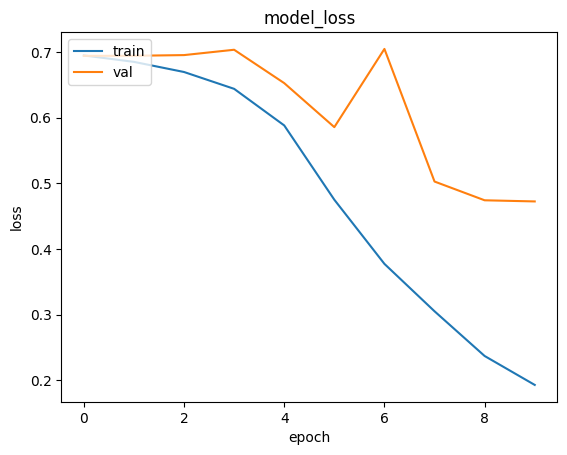

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

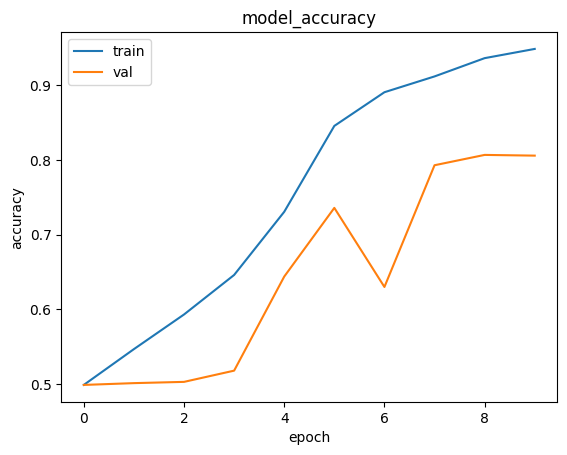

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [31]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(train_dataset)

391/391 [==============================] - 13s 33ms/step - loss: 0.2221 - accuracy: 0.9369


[0.2220536172389984, 0.9369199872016907]

## LSTM (MultiLayer and Bidirectional)

In [32]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(LSTM(64,return_sequences=True)),
    Bidirectional(LSTM(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 250, 128)          66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [33]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/lstm.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [34]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [35]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[model_checkpoint_callback])

Epoch 1/5
391/391 [==============================] - 69s 156ms/step - loss: 0.6442 - accuracy: 0.5986 - val_loss: 0.4592 - val_accuracy: 0.7938
Epoch 2/5
391/391 [==============================] - 21s 53ms/step - loss: 0.3389 - accuracy: 0.8634 - val_loss: 0.3289 - val_accuracy: 0.8639
Epoch 3/5
391/391 [==============================] - 22s 57ms/step - loss: 0.2464 - accuracy: 0.9104 - val_loss: 0.3574 - val_accuracy: 0.8642
Epoch 4/5
391/391 [==============================] - 21s 53ms/step - loss: 0.1999 - accuracy: 0.9331 - val_loss: 0.4127 - val_accuracy: 0.8565
Epoch 5/5
391/391 [==============================] - 21s 55ms/step - loss: 0.1715 - accuracy: 0.9462 - val_loss: 0.5202 - val_accuracy: 0.8346


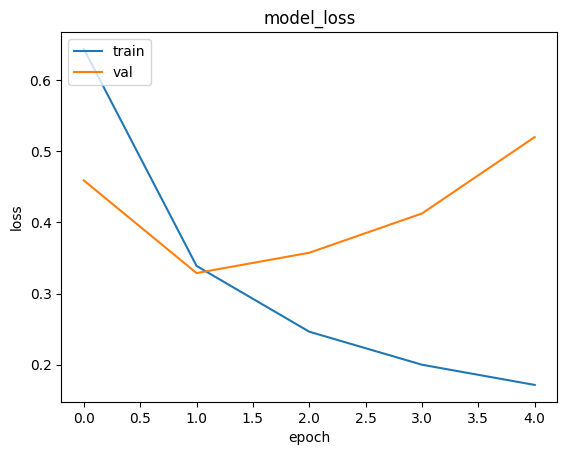

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

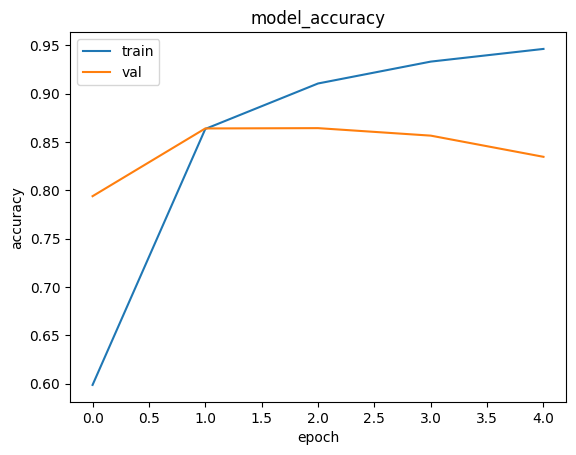

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [38]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 [==============================] - 5s 24ms/step - loss: 0.5089 - accuracy: 0.8387


[0.5089171528816223, 0.8387200236320496]

## GRU (MultiLayer and Bidirectional)

In [39]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(GRU(64,return_sequences=True)),
    Bidirectional(GRU(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 64)           640000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 250, 128)          49920     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [40]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/gru.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [41]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [42]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[])

Epoch 1/5
391/391 [==============================] - 71s 157ms/step - loss: 0.6920 - accuracy: 0.5236 - val_loss: 0.6869 - val_accuracy: 0.5903
Epoch 2/5
391/391 [==============================] - 21s 55ms/step - loss: 0.4696 - accuracy: 0.7776 - val_loss: 0.3439 - val_accuracy: 0.8544
Epoch 3/5
391/391 [==============================] - 20s 52ms/step - loss: 0.2787 - accuracy: 0.8950 - val_loss: 0.3431 - val_accuracy: 0.8655
Epoch 4/5
391/391 [==============================] - 20s 50ms/step - loss: 0.2313 - accuracy: 0.9178 - val_loss: 0.3893 - val_accuracy: 0.8579
Epoch 5/5
391/391 [==============================] - 21s 54ms/step - loss: 0.2008 - accuracy: 0.9308 - val_loss: 0.4339 - val_accuracy: 0.8552


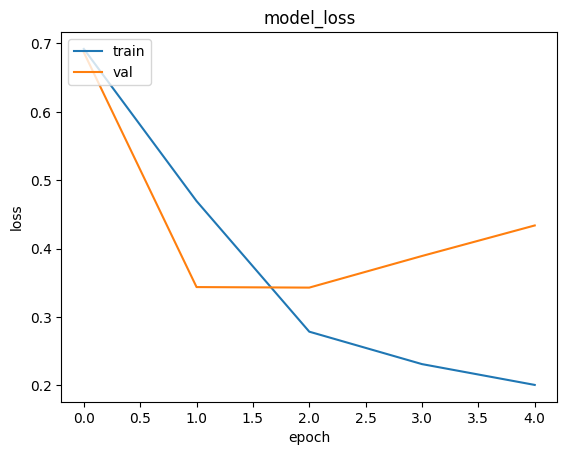

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

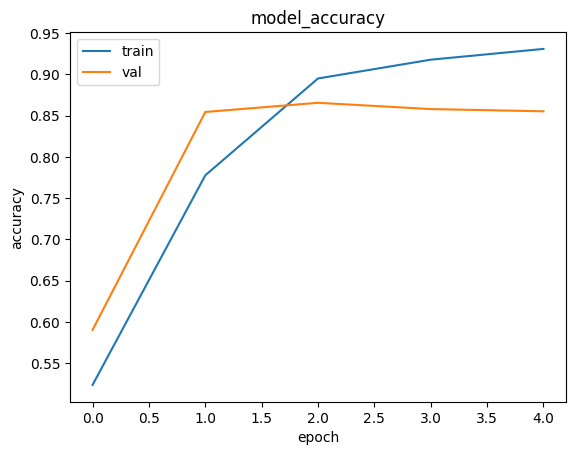

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [45]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 [==============================] - 5s 27ms/step - loss: 0.4314 - accuracy: 0.8565


[0.43141812086105347, 0.8564800024032593]

## Conv1D

In [46]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 300)          3000000   
                                                                 
 conv1d (Conv1D)             (None, 248, 32)           28832     
                                                                 
 flatten (Flatten)           (None, 7936)              0         
                                                                 
 dense_5 (Dense)             (None, 32)                253984    
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3282849 (12.52 MB)
Trainable params: 328

In [47]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/conv_1d.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [48]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [49]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[model_checkpoint_callback])

Epoch 1/5
391/391 [==============================] - 72s 166ms/step - loss: 0.6920 - accuracy: 0.5217 - val_loss: 0.6866 - val_accuracy: 0.5486
Epoch 2/5
391/391 [==============================] - 11s 29ms/step - loss: 0.5091 - accuracy: 0.7557 - val_loss: 0.3446 - val_accuracy: 0.8570
Epoch 3/5
391/391 [==============================] - 12s 30ms/step - loss: 0.2806 - accuracy: 0.8905 - val_loss: 0.3090 - val_accuracy: 0.8686
Epoch 4/5
391/391 [==============================] - 12s 30ms/step - loss: 0.2122 - accuracy: 0.9237 - val_loss: 0.3202 - val_accuracy: 0.8662
Epoch 5/5
391/391 [==============================] - 11s 29ms/step - loss: 0.1694 - accuracy: 0.9436 - val_loss: 0.3406 - val_accuracy: 0.8646


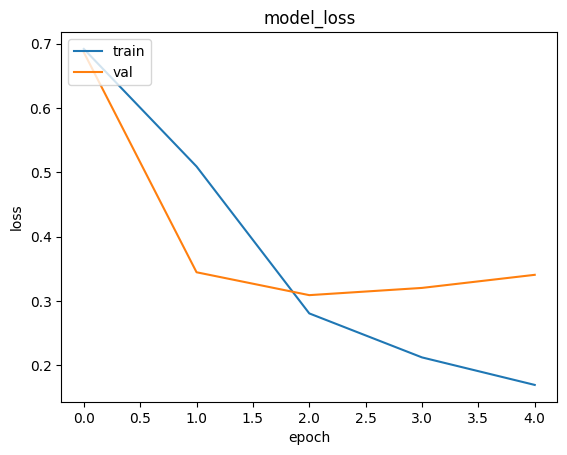

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

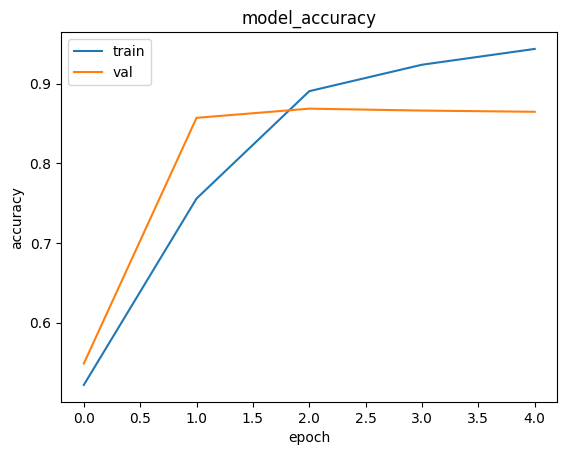

In [51]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [52]:
model.load_weights(checkpoint_filepath)

In [53]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 [==============================] - 3s 17ms/step - loss: 0.3102 - accuracy: 0.8674


[0.3101744055747986, 0.8674399852752686]

## Pretrained Word2Vec[Gensim]

In [54]:
word2vec=api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [55]:
word2vec.vectors.shape

(3000000, 300)

In [56]:
#print(word2vec.vocab)
len(word2vec['The'])

300

In [ ]:
word2vec.most_similar('Man')

In [ ]:
pretrained_embeddings=[]

In [ ]:
def first_caps(word):
  return word[0].upper()+word[1:]

In [ ]:
vectorize_layer.get_vocabulary()[2]

In [ ]:
#first_caps(vectorize_layer.get_vocabulary()[2])

In [ ]:
pretrained_embeddings=[]

In [ ]:
len(vectorize_layer.get_vocabulary())

In [ ]:
for i in range(len(vectorize_layer.get_vocabulary())):
  try:
    pretrained_embeddings.append(word2vec[vectorize_layer.get_vocabulary()[i]])
  except:
    print(vectorize_layer.get_vocabulary()[i])
    try:
      pretrained_embeddings.append(word2vec[first_caps(vectorize_layer.get_vocabulary()[i])])
      print('toupper')
    except:
      print('nosolution')
      pretrained_embeddings.append(random.normal(loc=0, scale=1, size=(EMBEDDING_DIM)))#reloaded_word_vectors[vectorize_layer.get_vocabulary()[i]])
  if i%1000==0:
    print('iis====================================',i)

In [ ]:
pretrained_embeddings_array=np.array(pretrained_embeddings)
print(pretrained_embeddings_array.shape)

In [ ]:
#np.save('/content/drive/MyDrive/nlp/sentiment_analysis/pretrained_embeddings',pretrained_embeddings_array)

In [ ]:
pretrained_embeddings_array=np.load('/content/drive/MyDrive/nlp/sentiment_analysis/pretrained_embeddings.npy')

In [ ]:
pretrained_embeddings_array.shape

In [ ]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        embeddings_initializer=tf.keras.initializers.Constant(pretrained_embeddings_array),
        trainable=True,
    ),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/conv_1d_word2vec.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

# Testing

In [ ]:
# test_pos="this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "
# test_neg="very good start, but movie started becoming boring at some point and unfortunately i didn't feel like this was properly produced as there was too much background noise, and the actors didn't look motivated at all "

In [ ]:
test_data=tf.data.Dataset.from_tensor_slices([["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "],
                                              ["very good start, but movie started becoming interesting at some point and fortunately at some point it started becoming much more fun, though there was too much background noise, so in all i liked this movie "],])


In [ ]:
def vectorizer_test(review):
    return vectorize_layer(review)
test_dataset=test_data.map(vectorizer_test)

In [ ]:
model.predict(test_dataset)